<a href="https://colab.research.google.com/github/logansmith9454/cse450/blob/main/notebooks/starter_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# !pip install scikit-learn==1.5.2
# !pip install --upgrade xgboost scikit-learn

In [16]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from IPython.display import display, HTML
from branca.colormap import LinearColormap
from google.colab import files

In [6]:
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20000 non-null  int64  
 1   date           20000 non-null  object 
 2   bedrooms       20000 non-null  int64  
 3   bathrooms      20000 non-null  float64
 4   sqft_living    20000 non-null  int64  
 5   sqft_lot       20000 non-null  int64  
 6   floors         20000 non-null  float64
 7   waterfront     20000 non-null  int64  
 8   view           20000 non-null  int64  
 9   condition      20000 non-null  int64  
 10  grade          20000 non-null  int64  
 11  sqft_above     20000 non-null  int64  
 12  sqft_basement  20000 non-null  int64  
 13  yr_built       20000 non-null  int64  
 14  yr_renovated   20000 non-null  int64  
 15  zipcode        20000 non-null  int64  
 16  lat            20000 non-null  float64
 17  long           20000 non-null  float64
 18  sqft_l

In [7]:
def format_data(dataset):
  dataset['is_renovated'] = (dataset['yr_renovated'] == 0).astype(int)
  ren_med = dataset[dataset['yr_renovated'] != 0]['yr_renovated'].median()
  dataset['yr_renovated'] = dataset['yr_renovated'].replace(0, ren_med)

  grade_bins = [0, 3, 7, 11, 13]
  grade_labels = ['low', 'medium', 'high', 'very high']
  dataset['grade_category'] = pd.cut(dataset['grade'], bins=grade_bins, labels=grade_labels)

  columns_to_drop = ['date', 'lat', 'long', 'grade']
  if 'price' in dataset.columns:
    y = dataset['price']
    columns_to_drop.append('price')
    X = dataset.drop(columns_to_drop, axis=1)
    X = pd.get_dummies(X, columns=discrete_features, drop_first=True)
    return X, y
  else:
    X = dataset.drop(columns_to_drop, axis=1)
    X = pd.get_dummies(X, columns=discrete_features, drop_first=True)
    return X

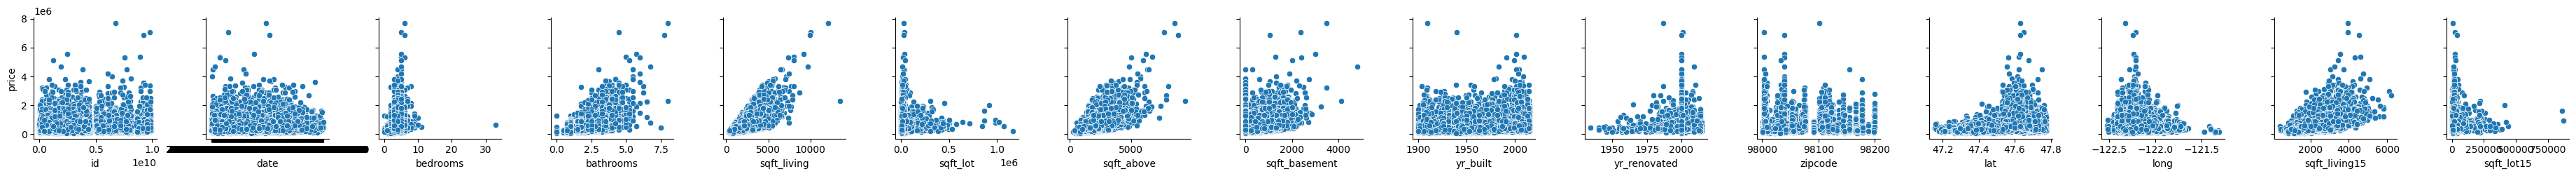

In [10]:
format_data(housing)

# Select a few features to visualize along with the price
continuous_features = ['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

# Create a pairplot to visualize the relationships
sns.pairplot(housing, y_vars=['price'], x_vars=continuous_features)

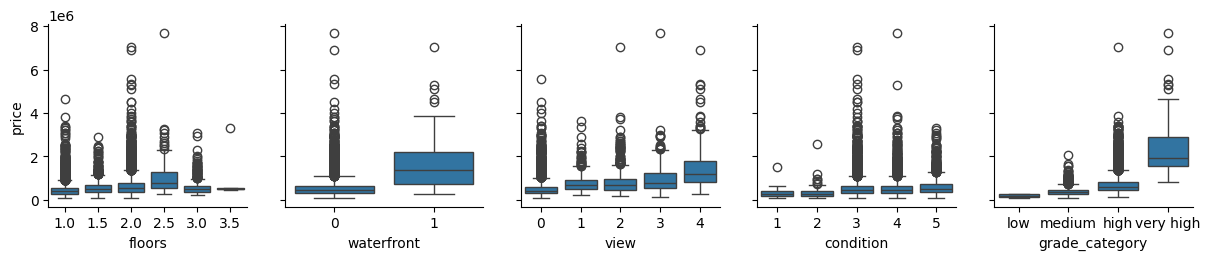

In [11]:
discrete_features = ['floors', 'waterfront', 'view', 'condition', 'grade_category']

g = sns.PairGrid(housing, y_vars=['price'], x_vars=discrete_features)
g.map(sns.boxplot)

In [12]:
X, y = format_data(housing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {mse**0.5:,.2f}")

Mean Squared Error: 26335862248.617695
Root Mean Squared Error: 162,283.28


In [13]:
# center_lat = housing['lat'].mean()
# center_lon = housing['long'].mean()

# m = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles='OpenStreetMap')

# # Create a color map based on price
# min_price = housing['price'].min()
# max_price = housing['price'].max()
# colormap = LinearColormap(['green', 'yellow', 'red'], vmin=min_price, vmax=max_price)

# # Add markers for each house, color-coded by price
# for idx, row in housing.iterrows():
#     folium.CircleMarker(
#         location=[row['lat'], row['long']],
#         radius=5,
#         color=colormap(row['price']),
#         fill=True,
#         fill_color=colormap(row['price']),
#         fill_opacity=0.7
#     ).add_to(m)

# # Add the colormap to the map
# colormap.add_to(m)

# display(m)

In [17]:
mini_holdout = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv")

# Apply the format_data function to the holdout dataset.
# Since the holdout set doesn't have 'price', format_data will return only X.
X_holdout = format_data(mini_holdout)

# Reindex X_holdout to match the columns of X_train
X_holdout = X_holdout.reindex(columns=X_train.columns, fill_value=0)


# Make predictions using the already trained model
predictions = model.predict(X_holdout)

predictions = np.array(predictions).astype(int)
print(predictions)
print(f"predictions: {len(predictions)}")
print(f"holdout: {len(mini_holdout)}")
output_df = pd.DataFrame(predictions, columns=['predictions'])

file_number = 1
file_name = f'{file_number}-mini-predictions.csv'
output_df.to_csv(file_name, index=False)
files.download(file_name)

[ 438824  731011  172681  469554  447886  373868  477562  220794  491403
  264050  313121  355720  441380  339143  262787  224107  897117  251871
  228987  431455  342844  472932  485781  470189  334194  259995  602282
  450590  481206  447296 1055227  585717  539769  630830  342105  621324
 1091965  626033  496540  510138  627034  456234  644685  829329  464366
  677295  248201  440701  504866  251252  482115  785766  552090  348158
  325581  488869  323667  355236  819248  483744  325303  259819  638812
  559408 1457104  477185  308691  594767  561791 1285237  437324  384589
  309219  660159  798031 1118113  529608  987301  820023  273127  560968]
predictions: 81
holdout: 81


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>